In [1]:
import h5py
import torch

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch import nn
from tqdm import tqdm
from torch import Tensor
from pathlib import Path
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [2]:
mpl.rcParams['figure.dpi'] = 350
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'
mpl.rcParams['axes.formatter.useoffset'] = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memory Checker

In [3]:
gpu_count = torch.cuda.device_count()
device_idx = torch.cuda.current_device()

print('Using CUDA:', torch.cuda.is_available(), '\n')
print('GPU count:', gpu_count, '\n')
print('Using GPU:', torch.cuda.current_device(), '\n')
print('Avliable devices:', '\n')

for i in range(gpu_count):

    print('   ', torch.cuda.get_device_name(i))

print()
print('current_device:', '\n')
print(
    '   ', 
    torch.cuda.get_device_name(device_idx),
    # '   ',
    # torch.cuda.device(device_idx)
)

Using CUDA: True 

GPU count: 8 

Using GPU: 0 

Avliable devices: 

    Tesla V100-SXM2-16GB
    Tesla V100-SXM2-16GB
    Tesla V100-SXM2-16GB
    Tesla V100-SXM2-16GB
    Tesla V100-SXM2-16GB
    Tesla V100-SXM2-16GB
    Tesla V100-SXM2-16GB
    Tesla V100-SXM2-16GB

current_device: 

    Tesla V100-SXM2-16GB


In [4]:
torch.cuda.memory_allocated(device=None)
print(
    'GPU', 
    torch.cuda.current_device(),
    'Reserved memory', 
    torch.cuda.memory_reserved()/1024/1024/1024
)

# Get Detailed info of your GPU
# print(torch.cuda.memory_summary())


GPU 0 Reserved memory 0.0


# Data Gen

In [5]:
TOTAL_DATA = 10000
HALF_DATA = int(TOTAL_DATA/2)
MIN_FREQ, MAX_FREQ = 100, 1000
IFOS, KERNEL = 1, 8192

DATA_BASE = Path.home() / 'Data' / 'pytorch_tutorial'
OUT_BASE = Path.home() / 'Outputs' / 'pytorch_tutorial'

TRAINING_FILE = DATA_BASE / 'training_data.h5'
VALIDATION_FILE = DATA_BASE / 'validation_data.h5'
TESTING_FILE = DATA_BASE / 'testing_data.h5'

Training Data

In [6]:
time = np.arange(-1, 1, 1/4096)
freq = 2*np.pi*np.random.uniform(MIN_FREQ, MAX_FREQ, HALF_DATA)
deviation = np.random.uniform(0.01, 0.1, TOTAL_DATA)

training_Input = np.random.normal(0, 1, (TOTAL_DATA, 8192))

for i in range(HALF_DATA):

    training_Input[i, :] += np.sin(freq[i]*time)*np.exp(-(time**2)/(deviation[i]))

training_target = np.r_[
    np.repeat(np.array([[1,0]]), HALF_DATA, axis=0),
    np.repeat(np.array([[0,1]]), HALF_DATA, axis=0)
]

Plots

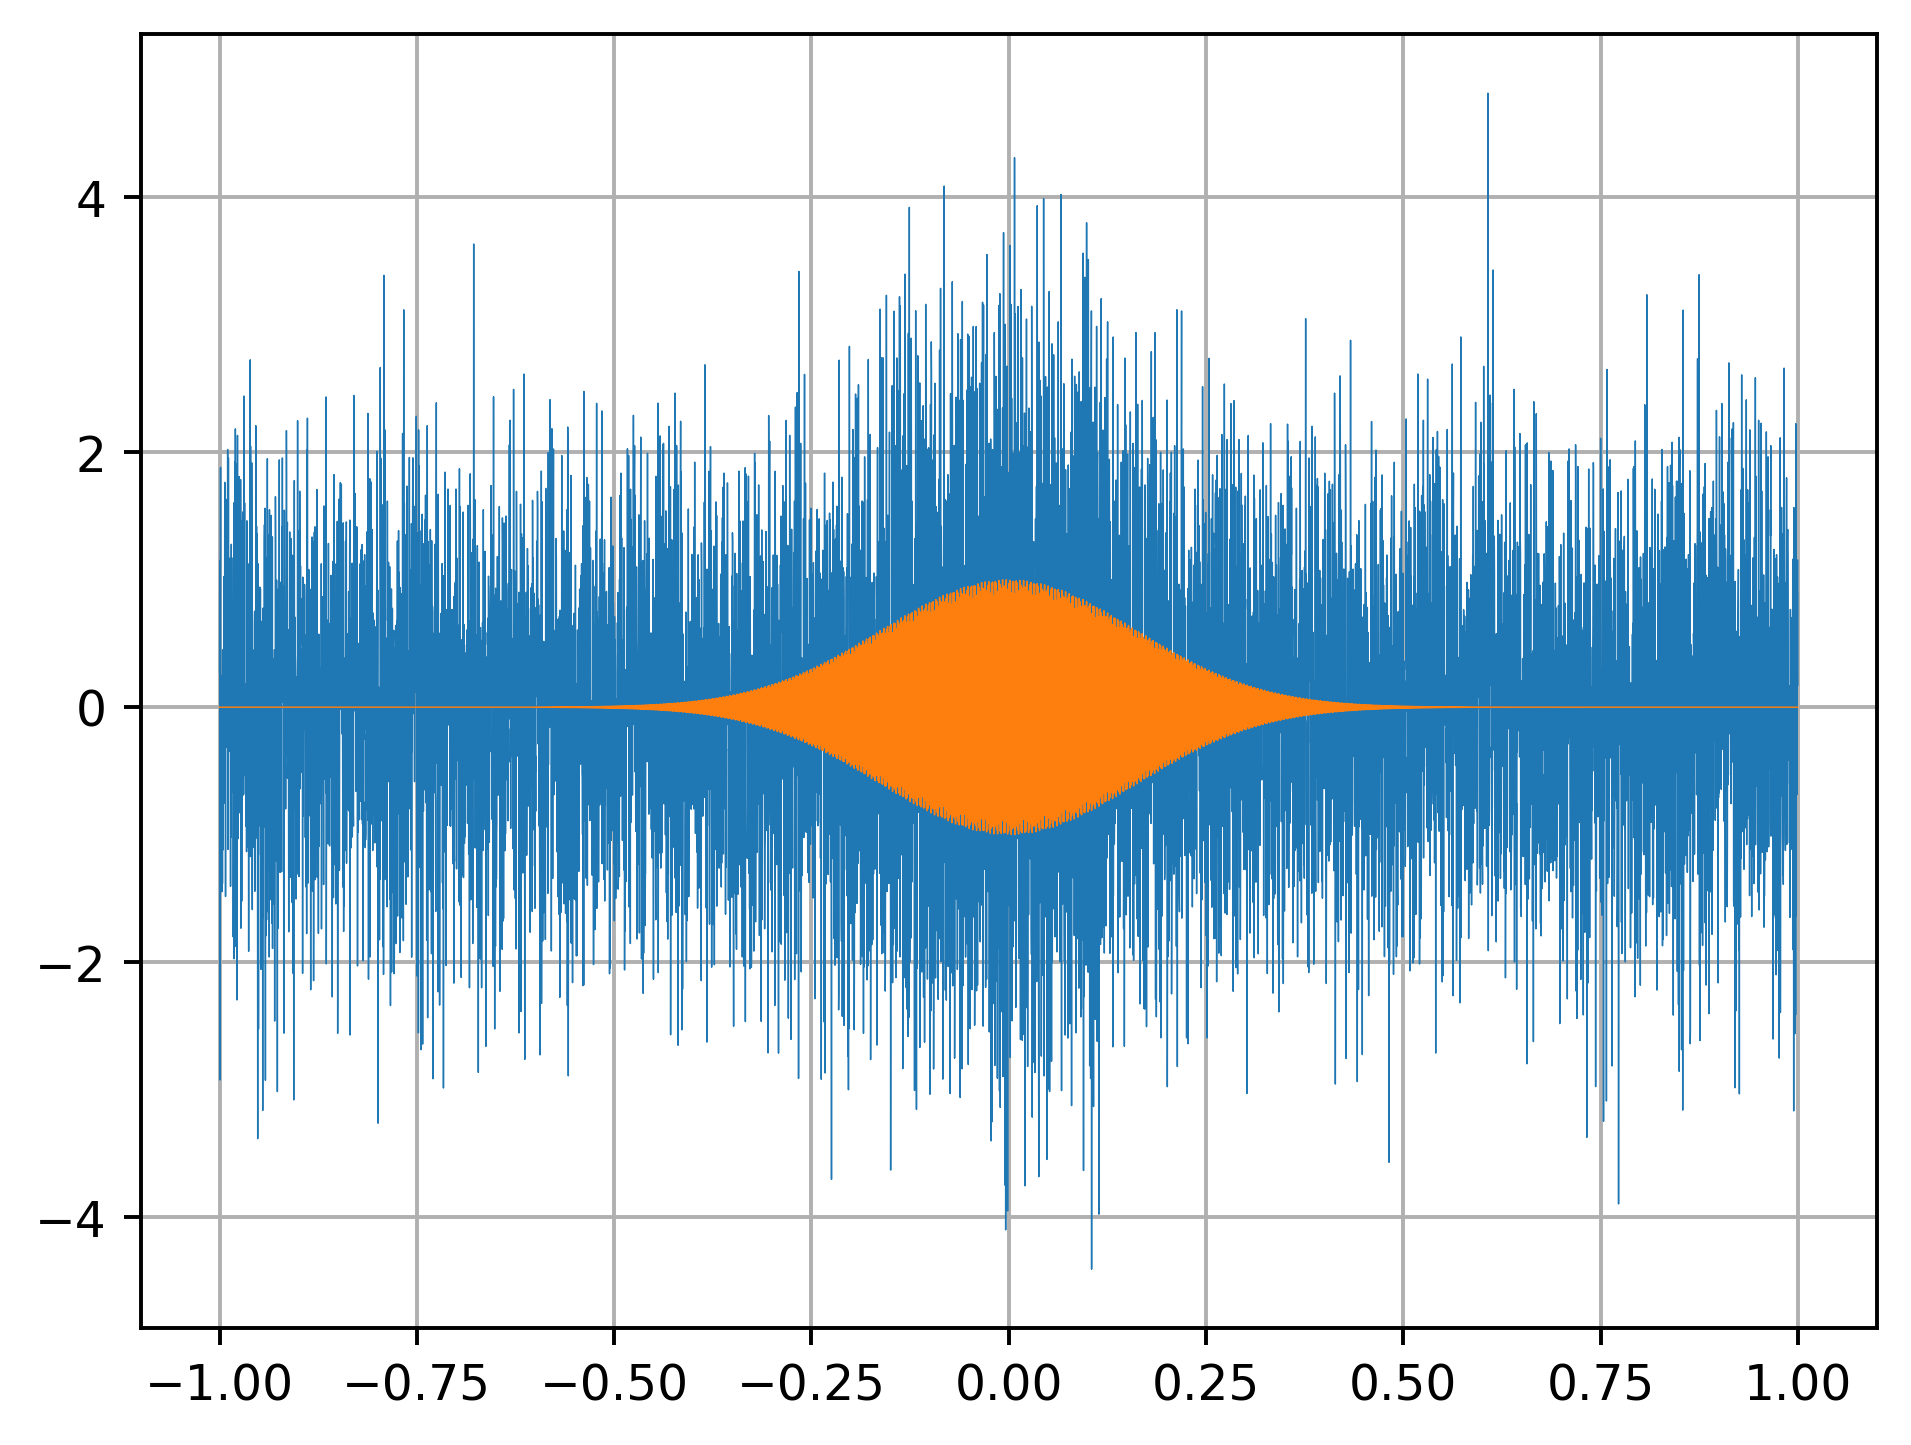

In [7]:
idx = 0
signal = np.sin(freq[idx]*time)*np.exp(-(time**2)/(deviation[idx]))
plt.plot(time, training_Input[idx]+signal, lw=0.3)
# plt.plot(time, noise[idx], lw=0.3)
plt.plot(time, signal, lw=0.3)
plt.show()
plt.close()

Validation Data

In [8]:
TOTAL_DATA = 5000
HALF_DATA = int(TOTAL_DATA/2)

In [9]:
freq = 2*np.pi*np.random.uniform(MIN_FREQ, MAX_FREQ, HALF_DATA)
deviation = np.random.uniform(0.01, 0.1, TOTAL_DATA)

validation_Input = np.random.normal(0, 1, (TOTAL_DATA, 8192))

for i in range(HALF_DATA):
    validation_Input[i, :] += np.sin(freq[i]*time)*np.exp(-(time**2)/(deviation[i]))

validation_Target = np.r_[
    np.repeat(np.array([[1,0]]), HALF_DATA, axis=0),
    np.repeat(np.array([[0,1]]), HALF_DATA, axis=0)
]

Test Data

In [10]:
TOTAL_DATA = 5000
HALF_DATA = int(TOTAL_DATA/2)

In [11]:
freq = 2*np.pi*np.random.uniform(MIN_FREQ, MAX_FREQ, HALF_DATA)
deviation = np.random.uniform(0.01, 0.1, TOTAL_DATA)

testing_Input = np.random.normal(0, 1, (TOTAL_DATA, 8192))

for i in range(HALF_DATA):
    testing_Input[i, :] += np.sin(freq[i]*time)*np.exp(-(time**2)/(deviation[i]))

testing_Target = np.r_[
    np.repeat(np.array([[1,0]]), HALF_DATA, axis=0),
    np.repeat(np.array([[0,1]]), HALF_DATA, axis=0)
]

In [12]:
with h5py.File(TRAINING_FILE, 'w') as g1:
    g1.create_dataset('Input', data=training_Input)
    g1.create_dataset('Target', data=training_target)

with h5py.File(VALIDATION_FILE, 'w') as g1:
    g1.create_dataset('Input', data=validation_Input)
    g1.create_dataset('Target', data=validation_Target)

with h5py.File(TESTING_FILE, 'w') as g1:
    g1.create_dataset('Input', data=testing_Input)
    g1.create_dataset('Target', data=testing_Target)

In [13]:
TRAINING_FILE, VALIDATION_FILE

(PosixPath('/home/hongyin.chen/Data/pytorch_tutorial/training_data.h5'),
 PosixPath('/home/hongyin.chen/Data/pytorch_tutorial/validation_data.h5'))

# DataLoader

In [14]:
class MyDataset(Dataset):

    def __init__(self, data, target):

        # Get data type from https://pytorch.org/docs/stable/tensors.html
        self.data = torch.FloatTensor(
            data.reshape([-1, IFOS, KERNEL])
        )
        # 
        self.targets = torch.LongTensor(target)
    
    def __len__(self):
        
        return len(self.data)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        return x, y

In [15]:
with h5py.File(TRAINING_FILE, 'r') as h1:

    print('Start Loading training data...')
    Strains = h1['Input'][:]
    targets = h1['Target'][:]

    dataset = MyDataset(Strains, targets)

    training_data = DataLoader(
        dataset, 
        batch_size=256, 
        shuffle=True
    )
    print('Training data Loaded!')
    
print()

with h5py.File(VALIDATION_FILE, 'r') as h2:

    print('Start Loading validataion data...')
    Strains_v = h2['Input'][:]
    targets_v = h2['Target'][:]

    dataset_v = MyDataset(Strains_v, targets_v)
    validation_data = DataLoader(
        dataset_v, 
        batch_size=32, 
        shuffle=True
    )
    print('Validation data Loaded!')

Start Loading training data...
Training data Loaded!

Start Loading validataion data...
Validation data Loaded!


In [16]:
print(training_data.dataset.data.shape)
print(training_data.dataset.targets.shape)

torch.Size([10000, 1, 8192])
torch.Size([10000, 2])


# Warmup

In [17]:
# Input Tensors

BATCH_SIZE, CHANNELS, SHAPE = 64, 10, 4096
input = torch.randn(BATCH_SIZE, CHANNELS, SHAPE)
print(input.shape)

torch.Size([64, 10, 4096])


In [18]:
# Linear layer
linear = nn.Linear(
    in_features=SHAPE,
    out_features=20
)

# Conv Layer
conv_1d = nn.Conv1d(
    in_channels=CHANNELS, 
    out_channels=20, 
    kernel_size=3, 
    stride=2
)

# AdaptiveAvgPool1d

pooling = nn.AdaptiveAvgPool1d(output_size=5)

# Get some outputs
linear_layer_output = linear(input)
conv_1d_layer_output = conv_1d(input)
pooling_layer_output = pooling(input)

print('Linear_layer_output:', linear_layer_output.shape)
print('Conv_1d_layer_output:', conv_1d_layer_output.shape)
print('Pooling_layer_output:', pooling_layer_output.shape)

Linear_layer_output: torch.Size([64, 10, 20])
Conv_1d_layer_output: torch.Size([64, 20, 2047])
Pooling_layer_output: torch.Size([64, 10, 5])


# Build a Model

In [19]:
class Super_Model(nn.Module):
    
    def __init__(
        self,
        num_ifos: int,
    ):
        super(Super_Model, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=num_ifos, 
            out_channels=10, 
            kernel_size=5,
            stride=2,
            padding=2
        )
        self.conv2 = nn.Conv1d(10, 20, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv1d(20, 10, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv1d(10, 5, kernel_size=5, stride=2, padding=2)
        self.conv1_drop = nn.Dropout1d()
        self.fc1 = nn.Linear(160, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv1_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool1d(self.conv1_drop(self.conv3(x)), 2))
        x = F.relu(F.max_pool1d(self.conv1_drop(self.conv4(x)), 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim = 1)

        return x

In [20]:
IFOS = 1

Kate_Moss = Super_Model(num_ifos = IFOS).to(device)
summary(Kate_Moss, (IFOS, 8192), 64, 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [64, 10, 4096]              60
            Conv1d-2             [64, 20, 1024]           1,020
         Dropout1d-3             [64, 20, 1024]               0
            Conv1d-4              [64, 10, 256]           1,010
         Dropout1d-5              [64, 10, 256]               0
            Conv1d-6                [64, 5, 64]             255
         Dropout1d-7                [64, 5, 64]               0
            Linear-8                   [64, 32]           5,152
            Linear-9                    [64, 2]              66
Total params: 7,563
Trainable params: 7,563
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.00
Forward/backward pass size (MB): 42.83
Params size (MB): 0.03
Estimated Total Size (MB): 44.86
---------------------------------------------

# Training

In [21]:
# model = FlyNN(8, 64, 1024, 128).to(device)
model = Super_Model(num_ifos = 1).to(device)

epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

opt = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=1e-5
)

cost_value = np.empty(epochs)
cost_valid_value = np.empty(epochs)

for i in range(epochs):
    t_cost = 0
    for j, (x, y) in enumerate(tqdm(training_data, desc=f'Epoch {i+1}')):
        x = x.to(device)
        y = y.to(device)

        p_value = model(x)
        cost = criterion(p_value, torch.argmax(y, dim = 1))
        
        opt.zero_grad()
        cost.backward()
        opt.step()
        
        t_cost += cost.item()

    cost_value[i] = t_cost/(j+1)
        
    print('========')
    print(f'Cost{round(cost_value[i], 2)}')
    print('========', '\n')

    with torch.no_grad():
        v_cost = 0
        for run, (a, b) in enumerate(validation_data):
            a = a.to(device)
            b = b.to(device)
            
            p_value = model(a)
            cost_valid = criterion(p_value, torch.argmax(b, dim = 1))
            
            v_cost += cost_valid.item()
            
        cost_valid_value[i] = v_cost/(run+1)
        
        print('===================')
        print(f'Validation Cost{round(cost_valid_value[i], 2)}')
        print('===================', '\n')

Epoch 1: 100%|██████████| 40/40 [00:00<00:00, 74.75it/s]


Cost0.69

Validation Cost0.69



Epoch 2: 100%|██████████| 40/40 [00:00<00:00, 124.84it/s]


Cost0.67

Validation Cost0.61



Epoch 3: 100%|██████████| 40/40 [00:00<00:00, 123.71it/s]


Cost0.44

Validation Cost0.36



Epoch 4: 100%|██████████| 40/40 [00:00<00:00, 125.49it/s]


Cost0.35

Validation Cost0.35



Epoch 5: 100%|██████████| 40/40 [00:00<00:00, 124.69it/s]


Cost0.34

Validation Cost0.34



Epoch 6: 100%|██████████| 40/40 [00:00<00:00, 124.70it/s]


Cost0.35

Validation Cost0.35



Epoch 7: 100%|██████████| 40/40 [00:00<00:00, 125.32it/s]


Cost0.34

Validation Cost0.34



Epoch 8: 100%|██████████| 40/40 [00:00<00:00, 123.65it/s]


Cost0.34

Validation Cost0.34



Epoch 9: 100%|██████████| 40/40 [00:00<00:00, 125.82it/s]


Cost0.34

Validation Cost0.35



Epoch 10: 100%|██████████| 40/40 [00:00<00:00, 124.49it/s]


Cost0.34

Validation Cost0.34



# Plots

In [22]:
total_epoch = np.linspace(1, epochs, epochs)
plt.title('Loss value to epoch')
plt.plot(total_epoch, cost_value, label = 'Training Set')
plt.plot(total_epoch, cost_valid_value, label = 'Validation Set')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.savefig(OUT_BASE / 'Loss.png', bbox_inches = 'tight')
plt.close()

In [23]:
t_metrix = np.zeros([2,2])
metrix = np.zeros([2,2])
with torch.no_grad():
    for num, (x, y) in enumerate(tqdm(training_data)):
        Real_label = y.numpy()
        Prediction = model(x.to(device)).cpu().detach().numpy()
        
        for i in range(2): 
            for j in range(2):
                if np.sum(Real_label[:,j]) != 0:
                    metrix[i, j] =  np.dot(Real_label[:,j], 
                                           Prediction[:,i]
                                          )/np.sum(Real_label[:,j])
                if np.sum(Real_label[:,j]) == 0 :
                    metrix[i, j] =  np.dot(Real_label[:,j], 
                                           Prediction[:,i]
                                          )/(np.sum(Real_label[:,j])+1e-20)
        t_metrix += metrix
    metrix = t_metrix/(num+1)
    TPR = metrix[0,0]
    FAR = metrix[0,1]/(metrix[0,0] + metrix[0,1])
    
print(f'TPR: {TPR}')
print(f'FAR: {FAR}')

lab = np.array([['True P', 'False P'], ['False N', 'True N']])
plt.figure()
color = plt.pcolormesh([metrix[1], metrix[0]], cmap = 'Wistia', vmin=0, vmax=1)
for i in range(2):
    for j in range(2):
        
        plt.text(i+.5, j+.5,
                 f'{lab[1-j,i]}\n{round(metrix[1-j,i],3)}', 
                 ha = 'center', 
                 va = 'center')
        
plt.xticks([.5, 1.5], ['Injection', 'Noise'])
plt.yticks([.5, 1.5], ['Noise', 'Injection'], rotation=45)
plt.xlabel('Real Value')
plt.ylabel('Predict', rotation=0)
plt.title(
    f'Training set with:     TPR: {round(metrix[0, 0], 3)}FAR: {round(FAR, 3)}'
)
plt.colorbar(color)
plt.savefig(OUT_BASE / 'Training set performance.png', bbox_inches = 'tight')
plt.close()

100%|██████████| 40/40 [00:00<00:00, 211.15it/s]


TPR: 0.9631299823932054
FAR: 0.03626739324029579


In [24]:
t_metrix = np.zeros([2,2])
metrix = np.zeros([2,2])

with torch.no_grad():
    for num, (x, y) in enumerate(tqdm(validation_data)):
        Real_label = y.numpy()
        Prediction = model(x.to(device)).cpu().detach().numpy()
        
        for i in range(2): 
            for j in range(2):
                if np.sum(Real_label[:,j]) != 0:
                    metrix[i, j] =  np.dot(Real_label[:,j], 
                                           Prediction[:,i]
                                          )/np.sum(Real_label[:,j])
                if np.sum(Real_label[:,j]) == 0 :
                    metrix[i, j] =  np.dot(Real_label[:,j], 
                                           Prediction[:,i]
                                          )/(np.sum(Real_label[:,j])+1e-20)
        t_metrix += metrix
    metrix = t_metrix/(num+1)
    TPR = metrix[0,0]
    FAR = metrix[0,1]/(metrix[0,0] + metrix[0,1])
    
print(f'TPR: {TPR}')
print(f'FAR: {FAR}')

lab = np.array([['True P', 'False P'], ['False N', 'True N']])
plt.figure()
color = plt.pcolormesh([metrix[1], metrix[0]], cmap = 'Wistia', vmin=0, vmax=1)
for i in range(2):
    for j in range(2):
        
        plt.text(i+.5, j+.5, 
                 f'{lab[1-j,i]}\n{round(metrix[1-j,i],3)}', 
                 ha = 'center', 
                 va = 'center')
        
plt.xticks([.5, 1.5], ['Injection', 'Noise'])
plt.yticks([.5, 1.5], ['Noise', 'Injection'], rotation=45)
plt.xlabel('Real Value')
plt.ylabel('Predict', rotation=0)
plt.title(
    f'Validation set with:   TPR: {round(metrix[0, 0], 3)} FAR: {round(FAR, 3)}'
)
plt.colorbar(color)
plt.savefig(OUT_BASE / 'Validation set performance.png', bbox_inches = 'tight')
plt.close()

100%|██████████| 157/157 [00:00<00:00, 542.81it/s]


TPR: 0.964053657407775
FAR: 0.03548667656989599


# Save

In [25]:
classifier = model.to('cpu')
torch.save(classifier, OUT_BASE / 'model.pt')

# Test

In [26]:
Kate_Moss = Super_Model(num_ifos = IFOS)
Kate_Moss = torch.load(OUT_BASE / 'model.pt')
Kate_Moss.eval()
Kate_Moss.to(device)

Super_Model(
  (conv1): Conv1d(1, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(10, 20, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv4): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv1_drop): Dropout1d(p=0.5, inplace=False)
  (fc1): Linear(in_features=160, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [27]:
with h5py.File(TESTING_FILE, 'r') as h2:

    Strains_t = h2['Input'][:]
    targets_t = h2['Target'][:]

    dataset_t = MyDataset(Strains_v, targets_v)
    test_data = DataLoader(
        dataset_t, 
        batch_size=32, 
        shuffle=True
    )

In [28]:
t_metrix = np.zeros([2,2])
metrix = np.zeros([2,2])

with torch.no_grad():
    for num, (x, y) in enumerate(tqdm(test_data)):
        Real_label = y.numpy()
        Prediction = Kate_Moss(x.to(device)).cpu().detach().numpy()
        
        for i in range(2): 
            for j in range(2):
                if np.sum(Real_label[:,j]) != 0:
                    metrix[i, j] =  np.dot(Real_label[:,j], 
                                           Prediction[:,i]
                                          )/np.sum(Real_label[:,j])
                if np.sum(Real_label[:,j]) == 0 :
                    metrix[i, j] =  np.dot(Real_label[:,j], 
                                           Prediction[:,i]
                                          )/(np.sum(Real_label[:,j])+1e-20)
        t_metrix += metrix
    metrix = t_metrix/(num+1)
    TPR = metrix[0,0]
    FAR = metrix[0,1]/(metrix[0,0] + metrix[0,1])
    
print(f'TPR: {TPR}')
print(f'FAR: {FAR}')

lab = np.array([['True P', 'False P'], ['False N', 'True N']])
plt.figure()
color = plt.pcolormesh([metrix[1], metrix[0]], cmap = 'Wistia', vmin=0, vmax=1)
for i in range(2):
    for j in range(2):
        
        plt.text(i+.5, j+.5, 
                 f'{lab[1-j,i]}\n{round(metrix[1-j,i],3)}', 
                 ha = 'center', 
                 va = 'center')
        
plt.xticks([.5, 1.5], ['Injection', 'Noise'])
plt.yticks([.5, 1.5], ['Noise', 'Injection'], rotation=45)
plt.xlabel('Real Value')
plt.ylabel('Predict', rotation=0)
plt.title(
    f'Test set with:   TPR: {round(metrix[0, 0], 3)} FAR: {round(FAR, 3)}'
)
plt.colorbar(color)
plt.savefig(OUT_BASE / 'Test set performance.png', bbox_inches = 'tight')
plt.close()

100%|██████████| 157/157 [00:00<00:00, 600.86it/s]


TPR: 0.999934709688737
FAR: 0.0028988528636808976


Two Gold!
